In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
from netCDF4 import Dataset
import pandas as pd
import properscoring as ps
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import warnings
import xarray as xr
from matplotlib import cm
from utils.evaluation import find_landfalling_tcs,tc_region,create_xarray,get_storm_coords
from utils.metrics import calculate_crps
from global_land_mask import globe
from scipy.interpolate import griddata
from utils.data import load_tc_data
from utils.plot import make_cmap
# from utils.metrics import calculate_fid
import xesmf as xe
import glob
warnings.filterwarnings("ignore")

sns.set_style("white")
sns.set_palette(sns.color_palette("Paired"))
sns.set_palette(sns.color_palette("Set2"))

# TODO: check which way the storms are rotating and how this is plotted - if using imshow it won't take into account
# the fact that mswep uses reverse latitude
# TODO: are the accumulated ones being plotted in the right places? like is it in the right order?

In [2]:
def plot_accumulated(data,lats,lons,vmin=0,vmax=200,plot='show',limit=1,cmap='Blues',title=False,levels=[0,50,100,150,200,250,300],centre_lats=None,centre_lons=None,intensity=None,ax=None,mask_oceans=False,cbar=False,cax=False,title_pos=False):
        """
        Plots the accumulated rainfall of a tropical cyclone while it's at tropical cyclone strength
        """
        data = np.where(data<limit,np.nan,data)
        lon2d,lat2d = np.meshgrid(lons,lats)
        if plot != 'ax':
                fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
        c = ax.contourf(lon2d,lat2d,data,vmin=vmin,vmax=vmax,levels=levels,cmap = cmap, transform=ccrs.PlateCarree())
        ax.add_feature(cfeature.COASTLINE,linewidth=1)
        ax.add_feature(cfeature.LAND, zorder=100,color='black',alpha=0.1)
        if centre_lats is not None:
                for i in range(len(centre_lats)):
                        if intensity[i] == 0.0:
                                colour = '#ffb600'
                                colour='black'
                        elif intensity[i] == 1.0:
                                colour =  '#ff9e00'
                                colour='black'
                        elif intensity[i] == 2.0:
                                colour = '#ff7900'
                                colour='black'
                        elif intensity[i] == 3.0:       
                                colour = '#ff6000'
                                colour='black'
                        elif intensity[i] == 4.0:
                                colour = '#ff4000' 
                                colour='black'
                        elif intensity[i]==5.0:
                                colour = '#ff2000' 
                                colour='black'
                        ax.plot(centre_lons[i:i+2],centre_lats[i:i+2],color=colour,linewidth=3)
        ax.outline_patch.set_linewidth(0.5)
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.5, linestyle='-')
        gl.xlabels_top = False
        gl.ylabels_right = False
        gl.xlabel_style = {'size': 14}
        gl.ylabel_style = {'size': 14}
        # ax.set_xticklabels(labelsize=20)
        # ax.set_yticklabels(labelsize=20)
        ax.tick_params(axis='x', labelsize=20)
        ax.tick_params(axis='y', labelsize=20)
        if plot != 'ax':
                cbar = plt.colorbar(c, shrink=0.78)
                # cbar.outline.set_linewidth(0.5)
                cbar.ax.tick_params(labelsize=6,width=0.5)
        
        if cbar == True:
                precip_cmap,precip_norm = make_cmap(high_vals=True)
                cbar = plt.colorbar(c,fraction=1.5, pad=-0.7,cmap=precip_cmap,ticks=levels,boundaries=levels, format='%1i',ax=cax)
                # cbar.ax.tick_params(labelsize=8,width=0.5)
                cbar.ax.tick_params(labelsize=20)

        if (title != False) and (title_pos == False):
                ax.set_title(title,fontsize=26,pad=15)
        elif (title != False) and (title_pos != False):
                x,y = title_pos
                print(x)
                print(y)
                ax.text(x,y,title,fontsize=30)
        

        if plot=='show':
                plt.show()
        elif plot=='save':
                plt.savefig('accumulated_rainfall.png',bbox_inches='tight',dpi=300)
        else:
                return ax

In [8]:
def accumulated_rain(storm,meta,real,pred_gan,inputs,flip=True):
	# grab mswep coordinate variables
	fp = '/bp1store/geog-tropical/data/Obs/MSWEP/3hourly_invertlat/2000342.00.nc'
	fp = '/bp1/geog-tropical/data/Obs/MSWEP/3hourly_invertlat/2000342.00.nc'
	d = Dataset(fp, 'r')
	lat = d.variables['lat'][:] #lat
	lon = d.variables['lon'][:] #lon
	print('lat shape: ',lat.shape)
	print('lon shape: ',lon.shape)
	# calculate lats and lons for storm
	lats,lons = tc_region(meta,storm,lat,lon)
	# initialise accumulated xarray
	# grid_x, grid_y = np.meshgrid(lats, lons)
	grid_x, grid_y = np.meshgrid(lons,lats)
	# a = np.zeros((grid_x.shape))
	print('grid_x shape: ',grid_x.shape)
	print('grid_y.shape: ', grid_y.shape)
	print('lons shape: ',lons.shape)
	print('lats shape: ',lats.shape)
	a = np.zeros((grid_y.shape))
	print('a shape',a.shape)
	accumulated_ds = create_xarray(lats,lons,a)
	accumulated_ds_pred = create_xarray(lats,lons,a)
	# accumulated_ds_input = create_xarray(lats,lons,a)
	# loop through storm time steps o generate accumulated rainfall
	for i in storm:
		storm_lats,storm_lons = get_storm_coords(lat,lon,meta,i)
		ds = create_xarray(storm_lats,storm_lons,real[i])
		ds_pred = create_xarray(storm_lats,storm_lons,pred_gan[i])
		input_lats,input_lons = get_storm_coords(np.arange(-89.5,90,1),np.arange(-179.5,180),meta,i)
		# ds_input = create_xarray(input_lats,input_lons,inputs[i])

		# if flip==True:
		# 	ds.precipitation.values = np.flip(ds.precipitation.values,axis=0)
		# 	ds_pred.precipitation.values = np.flip(ds_pred.precipitation.values,axis=0)

		# regrid so grids match
		regridder = xe.Regridder(ds, accumulated_ds, "bilinear")
		ds_out = regridder(ds)
		ds_pred_out = regridder(ds_pred)

		# regird the inputs
		# regridder = xe.Regridder(ds_input, accumulated_ds, "bilinear")
		# ds_input_out = regridder(ds_input)

		# add up rainfall
		accumulated_ds = accumulated_ds + ds_out
		accumulated_ds_pred = accumulated_ds_pred + ds_pred_out
		# accumulated_ds_input = accumulated_ds_input + ds_input_out

	return accumulated_ds,accumulated_ds_pred

In [4]:
# define mode
# mode = 'validation'
# mode = 'extreme_valid'
# load datasets
real,inputs,pred_cnn,pred_vaegan,pred_gan,pred_ensemble_vaegan,pred_ensemble_gan,meta = load_tc_data(set='validation',results='test')
real_x,inputs_x,pred_cnn_x,pred_vaegan_x,pred_gan_x,pred_vaegan_ensemble_x,pred_gan_ensemble_x,meta_extreme_valid = load_tc_data(set='extreme_valid',results='test')
# real_extreme_test,inputs_extreme_test,pred_cnn_extreme_test,pred_vaegan_extreme_test,pred_gan_extreme_test,pred_vaegan_ensemble_extreme_test,pred_gan_ensemble_extreme_test,meta_extreme_test = load_tc_data(set='extreme_test',results='test')
# inputs = np.load('/user/home/al18709/work/gan_predictions_20/validation_input-opt_improve.npy')[:,:,:,0]
hrmip = np.load('/user/home/al18709/work/CMIP6/HighResMIP/EC-Earth3p/historical/storm_rain.npy')[-28000:]
tcs = pd.read_csv('/user/work/al18709/ibtracks/tc_files.csv')
# regrid inputs
grid_in = {"lon": np.linspace(0, 100, 10), "lat": np.linspace(0, 100, 10)}
grid_out = {"lon": np.linspace(0, 100, 100), "lat": np.linspace(0, 100, 100)}
regridder = xe.Regridder(grid_in, grid_out, "bilinear")
inputs_hr = regridder(inputs)
hrmip_hr = regridder(hrmip)

In [5]:
# get list of landfalling tcs
# landfall_sids = find_landfalling_tcs(meta)
valid_sids = list(dict.fromkeys(meta['sid']))
# get valid sids
# assign sid variable to list of sid indices correspoinnding to storm timesteps
for sid in valid_sids:
	indices = meta.sid[meta.sid == sid].index.tolist()
	exec('sid_%s = indices' % sid)

# get extreme sids
# landfall_sids = find_landfalling_tcs(meta_extreme_valid,land=False)
extreme_valid_sids = list(dict.fromkeys(meta_extreme_valid['sid']))
for sid in extreme_valid_sids:
	indices = meta_extreme_valid.sid[meta_extreme_valid.sid == sid].index.tolist()
	exec('sid_%s = indices' % sid)

# train_sids = list(dict.fromkeys(meta_train['sid']))
# for sid in train_sids:
# 	indices = meta_train.sid[meta_train.sid == sid].index.tolist()
# 	exec('sid_%s = indices' % sid)
# print('valid sids',valid_sids)

# print('extreme sids',extreme_valid_sids)
# print(all_sids)

In [6]:
# get tracks
tracks = pd.read_csv('/user/work/al18709/ibtracks/tc_files.csv')

In [7]:
# meta_irene = pd.read_csv('/user/work/al18709/tc_data_mswep_extend_flipped/meta_2020138N10086.csv')
# irene_real = np.load('/user/home/al18709/work/gan_predictions_20/storm_real-opt_2020138N10086.npy')[:,:,:,0]
# irene_pred = np.load('/user/home/al18709/work/gan_predictions_20/storm_pred-opt_2020138N10086.npy')[:,:,:,0]
# irene_inputs = np.load('/user/home/al18709/work/gan_predictions_20/storm_input-opt_2020138N10086.npy')[:,:,:,0]
# sid_2020138N10086 = np.arange(len(irene_real[:,0,0]))
# print(sid_2020138N10086)
# print(irene_real.shape)
# print(len(irene_real[0]))
# accumulated_ds_1,accumulated_ds_pred_1 = accumulated_rain(sid_2020138N10086,meta_irene,irene_real,irene_pred,irene_inputs)
# irene_inputs_hr = regridder(irene_inputs)
# _,accumulated_ds_inputs_1 = accumulated_rain(sid_2020138N10086,meta_irene,irene_real,irene_inputs_hr,irene_inputs)
# storm_1 = '2020138N10086'

# # get tracks
# # centre_lats_6 = tracks['lat'].loc[tracks['sid']==storm_6].reset_index(drop=True)
# # centre_lons_6 = tracks['lon'].loc[tracks['sid']==storm_6].reset_index(drop=True)
# # intensity_6 = tracks['sshs'].loc[tracks['sid']==storm_6].reset_index(drop=True)

# centre_lats_1 = [19.8,20.55,21.37,22.05,22.83,23.5,24.33,24.63,25.09,25.38,25.21,25.4]
# centre_lons_1 = [87.7,87.95,88.09,88.35,88.63,89.05,89.28,89.64,89.91,90.05,89.62,89.6]
# intensity_1 = [1,1,1,1,1,1,1,1,1,1,1,1]

In [13]:
# Amphan

# Amphan 2020136N10088 NI 2020138N10086
meta_amphan = pd.read_csv('/user/work/al18709/tc_data_mswep_extend_flipped/meta_2020138N10086.csv')
amphan_real = np.load('/user/home/al18709/work/gan_predictions_20/storm_real-opt_2020138N10086.npy')[:,:,:,0]
amphan_pred = np.load('/user/home/al18709/work/gan_predictions_20/storm_pred-opt_2020138N10086.npy')[:,:,:,0]
amphan_inputs = np.load('/user/home/al18709/work/gan_predictions_20/storm_input-opt_2020138N10086.npy')[:,:,:,0]
sid_2020138N10086 = np.arange(len(amphan_real[:,0,0]))
amphan_inputs_hr = regridder(amphan_inputs)
print(sid_2020138N10086)
print(amphan_real.shape)
print(len(amphan_real[0]))
accumulated_ds,accumulated_ds_pred = accumulated_rain(sid_2020138N10086,meta_amphan,amphan_real,amphan_pred,amphan_inputs)
_,accumulated_ds_inputs = accumulated_rain(sid_2020138N10086,meta_amphan,amphan_real,amphan_inputs_hr,amphan_inputs)
storm = '2020138N10086'

# get tracks
centre_lats = tracks['lat'].loc[tracks['sid']==storm].reset_index(drop=True)
centre_lons = tracks['lon'].loc[tracks['sid']==storm].reset_index(drop=True)
intensity = tracks['sshs'].loc[tracks['sid']==storm].reset_index(drop=True)

centre_lats = [19.8,20.55,21.37,22.05,22.83,23.5,24.33,24.63,25.09,25.38,25.21,25.4]
centre_lons = [87.7,87.95,88.09,88.35,88.63,89.05,89.28,89.64,89.91,90.05,89.62,89.6]
intensity = [1,1,1,1,1,1,1,1,1,1,1,1]

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
(30, 100, 100)
100
lat shape:  (1800,)
lon shape:  (3600,)
lat lower:  953
lat upper:  1194
lon lower:  2609
lon upper:  2744
lats:  (241,)
lons:  (135,)
grid_x shape:  (241, 135)
grid_y.shape:  (241, 135)
lons shape:  (135,)
lats shape:  (241,)
a shape (241, 135)
lat shape:  (1800,)
lon shape:  (3600,)
lat lower:  953
lat upper:  1194
lon lower:  2609
lon upper:  2744
lats:  (241,)
lons:  (135,)
grid_x shape:  (241, 135)
grid_y.shape:  (241, 135)
lons shape:  (135,)
lats shape:  (241,)
a shape (241, 135)


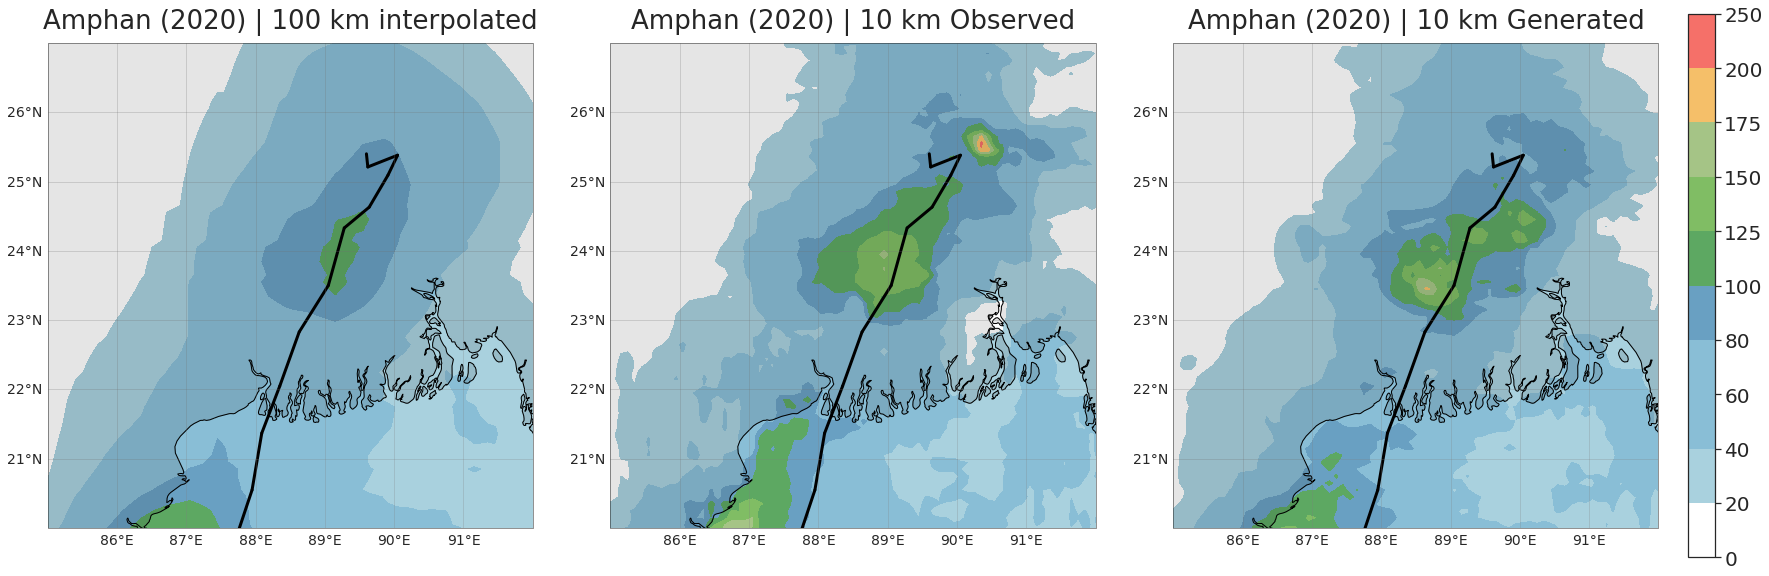

In [14]:
levels = [0, 1,2,3,4,6,10,15,20,25,40,50,100,150,200,250,300,350,400]
# levels = [0, 1, 2, 3, 5, 7, 10, 15, 20, 25, 30, 40, 50]#100,150,200,250,300,350,400,500]
# levels = np.arange(0,500,10)
levels = [10, 15, 20, 25, 30, 40, 50,75, 100,120,130, 150,180,200,250,300,350,400,450,500]
sns.set_style("white")
sns.set_context("notebook")
# define cmap
precip_cmap,precip_norm = make_cmap()

gridspec = {'width_ratios': [1,1,1,0.2]}
fig, axes = plt.subplots(1, 4, figsize=(32, 10), sharey=False,subplot_kw={'projection': ccrs.PlateCarree()}, gridspec_kw=gridspec)

axes[3].axis('off')

extent_1 = [119, 22, 122, 25]

# Irene 2011233N15301 validation NA
xlim_1 = (-80,-74)
ylim_1 = (33,39)

xlim_1 = (-82,-72)
ylim_1 = (33,43)

# xlim_1 = (-69,-63)
# ylim_1 = (15,21)

# xlim_1 = (85,92)
# ylim_1 = (20,27)

xlim = (85,92)
ylim = (20,27)

levels = [0,20, 40, 60, 80, 100, 125, 150, 175, 200,250]
# Irene
# levels = [0,20, 40, 60, 80, 100, 125, 150, 175, 200,250]
# levels = [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360]
title = 'Amphan (2020) | 100 km interpolated'
axes[0] = plot_accumulated(accumulated_ds_inputs['precipitation'],accumulated_ds_inputs['lat'].values,accumulated_ds['lon'].values,
							vmin=0,vmax=375,cmap=precip_cmap,levels = levels,plot='ax',centre_lats=centre_lats,
							centre_lons=centre_lons,intensity=intensity,ax=axes[0],mask_oceans=True,title=title)

title = 'Amphan (2020) | 10 km Observed'
axes[1] = plot_accumulated(accumulated_ds['precipitation'],accumulated_ds['lat'].values,accumulated_ds['lon'].values,
							vmin=0,vmax=375,cmap=precip_cmap,levels = levels,plot='ax',centre_lats=centre_lats,
							centre_lons=centre_lons,intensity=intensity,ax=axes[1],mask_oceans=True,title=title)
title = 'Amphan (2020) | 10 km Generated'
axes[2] = plot_accumulated(accumulated_ds_pred['precipitation'],accumulated_ds_pred['lat'].values,accumulated_ds_pred['lon'].values,
							vmin=0,vmax=375,cmap=precip_cmap,levels = levels,plot='ax',centre_lats=centre_lats,centre_lons=centre_lons,
							intensity=intensity,ax=axes[2],mask_oceans=True,title=title,cbar=True,cax=axes[3])
axes[0].set_xlim(xlim)
axes[0].set_ylim(ylim)
axes[1].set_xlim(xlim)
axes[1].set_ylim(ylim)
axes[2].set_xlim(xlim)
axes[2].set_ylim(ylim)


plt.savefig('amphan.png',bbox_inches='tight',dpi=600)

In [8]:
# Irene 2011233N15301 validation NA
accumulated_ds_1,accumulated_ds_pred_1 = accumulated_rain(sid_2011233N15301,meta,real,pred_gan,inputs)

meta_irene = pd.read_csv('/user/work/al18709/tc_data_mswep_extend_flipped/meta_2011233N15301.csv')
irene_real = np.load('/user/home/al18709/work/gan_predictions_20/storm_real-opt_2011233N15301.npy')[:,:,:,0]
irene_pred = np.load('/user/home/al18709/work/gan_predictions_20/storm_pred-opt_2011233N15301.npy')[:,:,:,0]
irene_inputs = np.load('/user/home/al18709/work/gan_predictions_20/storm_input-opt_2011233N15301.npy')[:,:,:,0]
irene_inputs_hr = regridder(irene_inputs)
sid_2011233N15301 = np.arange(len(irene_real[:,0,0]))
accumulated_ds_1,accumulated_ds_pred_1 = accumulated_rain(sid_2011233N15301,meta_irene,irene_real,irene_pred,irene_inputs)
_,accumulated_ds_inputs_1 = accumulated_rain(sid_2011233N15301,meta_irene,irene_real,irene_inputs_hr,irene_inputs)
storm_1 = '2011233N15301'

# storm_1 = '2011233N15301'
# get tracks
centre_lats_1 = tracks['lat'].loc[tracks['sid']==storm_1].reset_index(drop=True)
centre_lons_1 = tracks['lon'].loc[tracks['sid']==storm_1].reset_index(drop=True)
intensity_1 = tracks['sshs'].loc[tracks['sid']==storm_1].reset_index(drop=True)

lat shape:  (1800,)
lon shape:  (3600,)
lat lower:  1005
lat upper:  1383
lon lower:  974
lon upper:  1252
lats:  (378,)
lons:  (278,)
grid_x shape:  (378, 278)
grid_y.shape:  (378, 278)
lons shape:  (278,)
lats shape:  (378,)
a shape (378, 278)
lat shape:  (1800,)
lon shape:  (3600,)
lat lower:  1005
lat upper:  1383
lon lower:  974
lon upper:  1252
lats:  (378,)
lons:  (278,)
grid_x shape:  (378, 278)
grid_y.shape:  (378, 278)
lons shape:  (278,)
lats shape:  (378,)
a shape (378, 278)
lat shape:  (1800,)
lon shape:  (3600,)
lat lower:  1005
lat upper:  1383
lon lower:  974
lon upper:  1252
lats:  (378,)
lons:  (278,)
grid_x shape:  (378, 278)
grid_y.shape:  (378, 278)
lons shape:  (278,)
lats shape:  (378,)
a shape (378, 278)


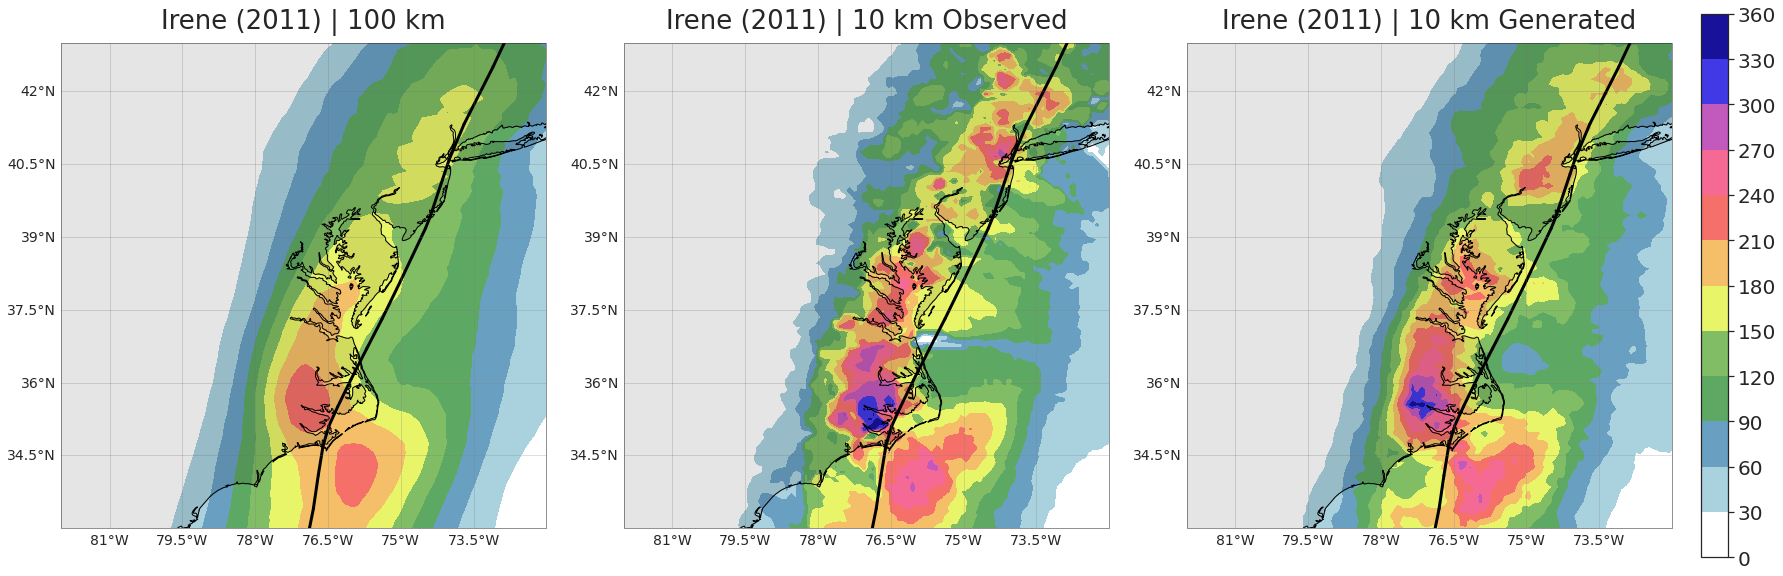

In [9]:
levels = [0, 1,2,3,4,6,10,15,20,25,40,50,100,150,200,250,300,350,400]
# levels = [0, 1, 2, 3, 5, 7, 10, 15, 20, 25, 30, 40, 50]#100,150,200,250,300,350,400,500]
# levels = np.arange(0,500,10)
levels = [10, 15, 20, 25, 30, 40, 50,75, 100,120,130, 150,180,200,250,300,350,400,450,500]
sns.set_style("white")
sns.set_context("notebook")
# define cmap
precip_cmap,precip_norm = make_cmap()

gridspec = {'width_ratios': [1,1,1,0.2]}
fig, axes = plt.subplots(1, 4, figsize=(32, 10), sharey=False,subplot_kw={'projection': ccrs.PlateCarree()}, gridspec_kw=gridspec)

axes[3].axis('off')

extent_1 = [119, 22, 122, 25]

# Irene 2011233N15301 validation NA
xlim_1 = (-80,-74)
ylim_1 = (33,39)

xlim_1 = (-82,-72)
ylim_1 = (33,43)

# xlim_1 = (-69,-63)
# ylim_1 = (15,21)

# xlim_1 = (85,92)
# ylim_1 = (20,27)

# Irene
levels = [0,20, 40, 60, 80, 100, 125, 150, 175, 200,250]
levels = [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360]
title = 'Irene (2011) | 100 km'
axes[0] = plot_accumulated(accumulated_ds_inputs_1['precipitation'],accumulated_ds_inputs_1['lat'].values,accumulated_ds_1['lon'].values,
							vmin=0,vmax=375,cmap=precip_cmap,levels = levels,plot='ax',centre_lats=centre_lats_1,
							centre_lons=centre_lons_1,intensity=intensity_1,ax=axes[0],mask_oceans=True,title=title)

title = 'Irene (2011) | 10 km Observed'
axes[1] = plot_accumulated(accumulated_ds_1['precipitation'],accumulated_ds_1['lat'].values,accumulated_ds_1['lon'].values,
							vmin=0,vmax=375,cmap=precip_cmap,levels = levels,plot='ax',centre_lats=centre_lats_1,
							centre_lons=centre_lons_1,intensity=intensity_1,ax=axes[1],mask_oceans=True,title=title)
title = 'Irene (2011) | 10 km Generated'
axes[2] = plot_accumulated(accumulated_ds_pred_1['precipitation'],accumulated_ds_pred_1['lat'].values,accumulated_ds_pred_1['lon'].values,
							vmin=0,vmax=375,cmap=precip_cmap,levels = levels,plot='ax',centre_lats=centre_lats_1,centre_lons=centre_lons_1,
							intensity=intensity_1,ax=axes[2],mask_oceans=True,title=title,cbar=True,cax=axes[3])
axes[0].set_xlim(xlim_1)
axes[0].set_ylim(ylim_1)
axes[1].set_xlim(xlim_1)
axes[1].set_ylim(ylim_1)
axes[2].set_xlim(xlim_1)
axes[2].set_ylim(ylim_1)


plt.savefig('irene.png',bbox_inches='tight',dpi=600)

In [10]:
population_file = '/user/home/al18709/work/population/gpw_v4_population_density_rev11_2pt5_min.nc'
pop = xr.load_dataset(population_file)


In [11]:
# print(pop['Population Density, v4.11 (2000, 2005, 2010, 2015, 2020): 2.5 arc-minutes'])
lats = pop.latitude
lons = pop.longitude
print(lats)

<xarray.DataArray 'latitude' (latitude: 4320)>
array([ 89.979167,  89.9375  ,  89.895833, ..., -89.895833, -89.9375  ,
       -89.979167])
Coordinates:
  * latitude  (latitude) float64 89.98 89.94 89.9 89.85 ... -89.9 -89.94 -89.98
Attributes:
    units:      degrees_north
    long_name:  latitude


(4320, 8640)


<function matplotlib.pyplot.show(close=None, block=None)>

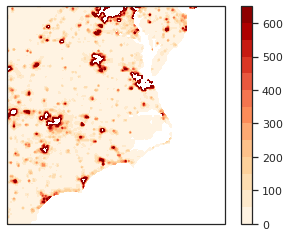

In [12]:
data = pop['Population Density, v4.11 (2000, 2005, 2010, 2015, 2020): 2.5 arc-minutes'].values[2]
print(data.shape)
lon2d,lat2d = np.meshgrid(lons,lats)
levels = [0, 50,100,150,200,250,300,350,400,450,500,550,600,650]
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
c = ax.contourf(lon2d,lat2d,data,levels=levels,cmap='OrRd',transform=ccrs.PlateCarree())
plt.colorbar(c)
xlim_1 = (-80,-74)
ylim_1 = (33,39)
# xlim_1 = (-69,-63)
# ylim_1 = (15,21)
# xlim_1 = (85,92)
# ylim_1 = (20,27)
ax.set_xlim(xlim_1)
ax.set_ylim(ylim_1)
plt.show

In [13]:
min_lon = -80
min_lat = 33
max_lon = -74
max_lat = 39

min_lon = -74.5
min_lat = 40
max_lon = -73.5
max_lat = 41

# min_lon = 85
# min_lat = 20 
# max_lon = 92
# max_lat = 27

mask_lon = (accumulated_ds_inputs_1.lon >= min_lon) & (accumulated_ds_inputs_1.lon <= max_lon)
mask_lat = (accumulated_ds_inputs_1.lat >= min_lat) & (accumulated_ds_inputs_1.lat <= max_lat)
cropped_pop = pop.sel(latitude=slice(max_lat,min_lat), longitude=slice(min_lon,max_lon))
# cropped_pop = cropped_pop/np.nanmax(cropped_pop['Population Density, v4.11 (2000, 2005, 2010, 2015, 2020): 2.5 arc-minutes'].values[2])
cropped_inputs = accumulated_ds_inputs_1.where(mask_lon & mask_lat, drop=True)

cropped_obs = accumulated_ds_1.where(mask_lon & mask_lat, drop=True)
# cropped_inputs = cropped_inputs/np.nanmax(cropped_obs['precipitation'])

cropped_pred = accumulated_ds_pred_1.where(mask_lon & mask_lat, drop=True)
# cropped_pred = cropped_pred/np.nanmax(cropped_obs['precipitation'])
# cropped_obs = cropped_obs/np.nanmax(cropped_obs['precipitation'])
# print(np.nanmax(cropped_pred.precipitation))
# print(np.nanmax(cropped_obs.precipitation))
# print(np.nanmax(cropped_inputs.precipitation))
# print(np.nanmax(cropped_obs['precipitation']))


In [14]:

grid_in = {"lon": cropped_pop.longitude, "lat": cropped_pop.latitude}
grid_out = {"lon": cropped_inputs.lon, "lat": cropped_inputs.lat}
regridder = xe.Regridder(grid_in, grid_out, "bilinear")
cropped_pop_regrid = regridder(cropped_pop)

In [15]:
print(cropped_pop_regrid['Population Density, v4.11 (2000, 2005, 2010, 2015, 2020): 2.5 arc-minutes'].values.shape)

(20, 10, 10)


In [16]:
grid_out = {"lon": cropped_pop.longitude, "lat": cropped_pop.latitude}
grid_in = {"lon": cropped_inputs.lon, "lat": cropped_inputs.lat}
regridder = xe.Regridder(grid_in, grid_out, "bilinear")
cropped_inputs_regrid = regridder(cropped_inputs)
cropped_pred_regrid = regridder(cropped_pred)
cropped_obs_regrid = regridder(cropped_obs)

In [43]:
exposure_inputs = cropped_pop['Population Density, v4.11 (2000, 2005, 2010, 2015, 2020): 2.5 arc-minutes'].values[2]*cropped_inputs_regrid
exposure_obs = cropped_pop['Population Density, v4.11 (2000, 2005, 2010, 2015, 2020): 2.5 arc-minutes'].values[2]*cropped_obs_regrid
exposure_pred = cropped_pop['Population Density, v4.11 (2000, 2005, 2010, 2015, 2020): 2.5 arc-minutes'].values[2]*cropped_pred_regrid


def exposure_calc(population, rain):
	""" number of people exposed to over 200mm in New York"""
	# population[rain['precipitation'] < 200] = 0
	print('max rain',np.max(rain['precipitation'].values))
	population = population.where(rain['precipitation'].values > 200,0)
	exposure = np.nansum(population['Population Density, v4.11 (2000, 2005, 2010, 2015, 2020): 2.5 arc-minutes'].values[2])
	return exposure

exposure_inputs = exposure_calc(cropped_pop,cropped_inputs_regrid)
print(exposure_inputs)
exposure_obs = exposure_calc(cropped_pop,cropped_obs_regrid)
print(exposure_obs)
exposure_pred = exposure_calc(cropped_pop,cropped_pred_regrid)
print(exposure_pred)

max rain 165.4201620143512
0.0
max rain 276.5182339632242
346835.12
max rain 208.34166101716716
17708.146


In [39]:
# exposure_inputs = exposure_inputs/np.nanmax(exposure_obs['precipitation'].values)
# exposure_pred = exposure_pred/np.nanmax(exposure_obs['precipitation'].values)

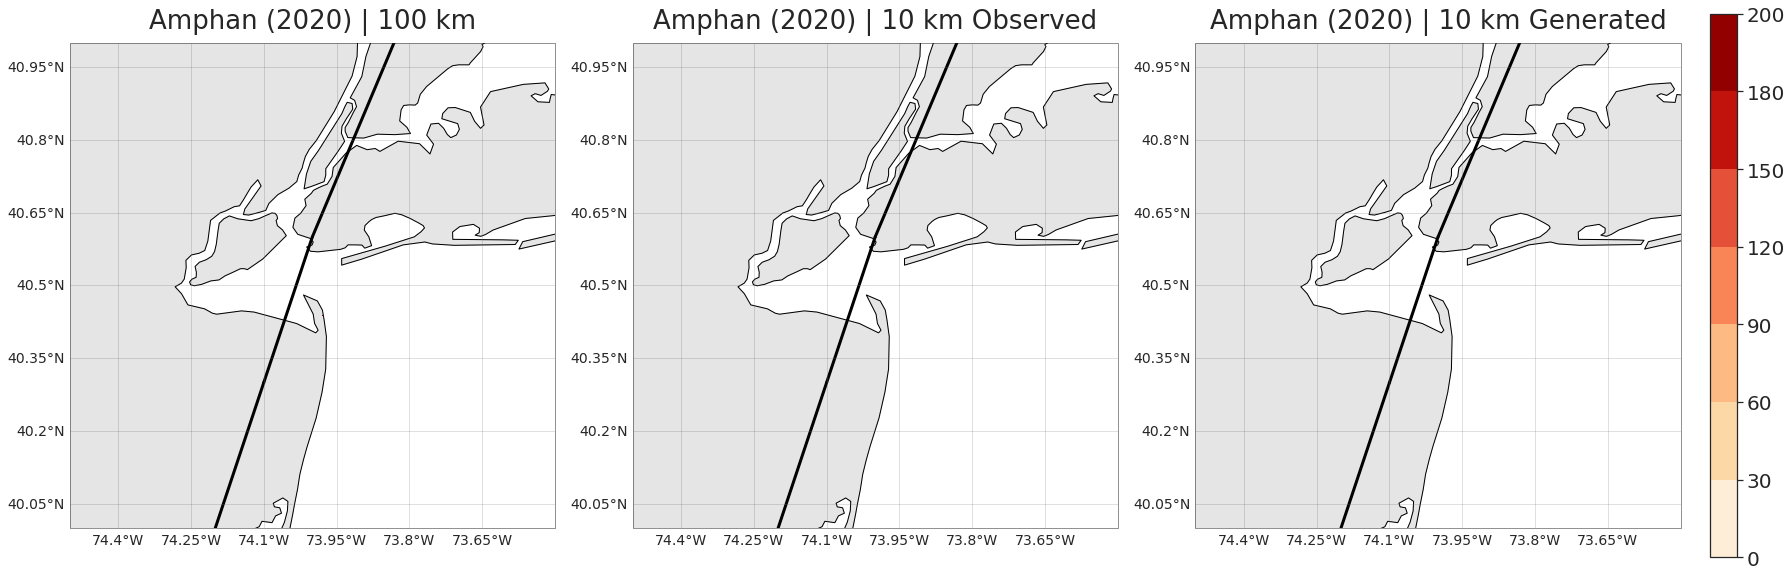

In [40]:
levels = [0.5, 1, 2, 3, 4, 5,7, 10,12,13, 15,18,20,25,30,35,40,45,50]
sns.set_style("white")
sns.set_context("notebook")
# define cmap
precip_cmap,precip_norm = make_cmap()

# gridspec = {'width_ratios': [1,1,0.2,1,1, 0.2]}
gridspec = {'width_ratios': [1,1,1,0.2]}
# fig, axes = plt.subplots(3, 6, figsize=(32, 20), sharey=False,subplot_kw={'projection': ccrs.PlateCarree()}, gridspec_kw=gridspec)
fig, axes = plt.subplots(1, 4, figsize=(32, 10), sharey=False,subplot_kw={'projection': ccrs.PlateCarree()}, gridspec_kw=gridspec)
axes[3].axis('off')

extent_1 = [119, 22, 122, 25]

# Irene 2011233N15301 validation NA
xlim_1 = (-80,-74)
ylim_1 = (33,39)


min_lon = -74.5
min_lat = 40
max_lon = -73.5
max_lat = 41


xlim_1 = (-74.5,-73.5)
ylim_1 = (40,41)

# xlim_1 = (-77.5,-76)
# ylim_1 = (34.5,36)

# xlim_1 = (-77.2,-76.2)
# ylim_1 = (36.5,37.5)

# min_lon = -80
# min_lat = 33
# max_lon = -74
# max_lat = 39

# xlim_1 = (85,92)
# ylim_1 = (20,27)

exposure_cmap = 'OrRd'

# Irene
levels = [0, 30, 60, 90, 120, 150, 180, 200]
# levels = [0,50000,55000,100000,150000,200000,250000,300000,350000,400000,450000,500000]
# levels = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
# levels = [0,0.001,0.002,0.003,0.004,0.005,0.006,0.06,0.07,0.08,0.09,0.1]
# levels = [1,2,3,4,5,6,7,8,9,10]
# levels = [0,0.001,0.005,0.01,0.02,0.03]
title = 'Amphan (2020) | 100 km'
axes[0] = plot_accumulated(exposure_inputs['precipitation'],cropped_pop['latitude'].values,cropped_pop['longitude'].values,
							vmin=0,vmax=200,cmap=exposure_cmap,levels = levels,plot='ax',centre_lats=centre_lats_1,
							centre_lons=centre_lons_1,intensity=intensity_1,ax=axes[0],mask_oceans=True,title=title)

title = 'Amphan (2020) | 10 km Observed'
axes[1] = plot_accumulated(exposure_obs['precipitation'],cropped_pop['latitude'].values,cropped_pop['longitude'].values,
							vmin=0,vmax=200,cmap=exposure_cmap,levels = levels,plot='ax',centre_lats=centre_lats_1,
							centre_lons=centre_lons_1,intensity=intensity_1,ax=axes[1],mask_oceans=True,title=title)
title = 'Amphan (2020) | 10 km Generated'
axes[2] = plot_accumulated(exposure_pred['precipitation'],cropped_pop['latitude'].values,cropped_pop['longitude'].values,
							vmin=0,vmax=200,cmap=exposure_cmap,levels = levels,plot='ax',centre_lats=centre_lats_1,centre_lons=centre_lons_1,
							intensity=intensity_1,ax=axes[2],mask_oceans=True,title=title,cbar=True,cax=axes[3])
axes[0].set_xlim(xlim_1)
axes[0].set_ylim(ylim_1)
axes[1].set_xlim(xlim_1)
axes[1].set_ylim(ylim_1)
axes[2].set_xlim(xlim_1)
axes[2].set_ylim(ylim_1)


plt.savefig('irene_exposure.png',bbox_inches='tight',dpi=600)

In [41]:
print(np.nanmean(exposure_inputs['precipitation'].values))
print(np.nanmean(exposure_obs['precipitation'].values))
print(np.nanmean(exposure_pred['precipitation'].values))

print(np.nanmax(exposure_inputs['precipitation'].values))
print(np.nanmax(exposure_obs['precipitation'].values))
print(np.nanmax(exposure_pred['precipitation'].values))

print(np.nansum(exposure_inputs['precipitation'].values))
print(np.nansum(exposure_obs['precipitation'].values))
print(np.nansum(exposure_pred['precipitation'].values))

397545.23540769506
487037.3203837176
440058.2807347476
5043850.272095072
6013744.785452056
5337934.575204164
164186182.22337806
201146413.31847537
181744069.94345075


In [42]:
print(np.nanmean(cropped_inputs_regrid['precipitation'].values))
print(np.nanmean(cropped_obs_regrid['precipitation'].values))
print(np.nanmean(cropped_pred_regrid['precipitation'].values))

124.62129906908561
154.70847437069378
141.59608556296178


In [43]:

print(np.nanmean(cropped_pop['Population Density, v4.11 (2000, 2005, 2010, 2015, 2020): 2.5 arc-minutes'].values[2]))


2689.4019


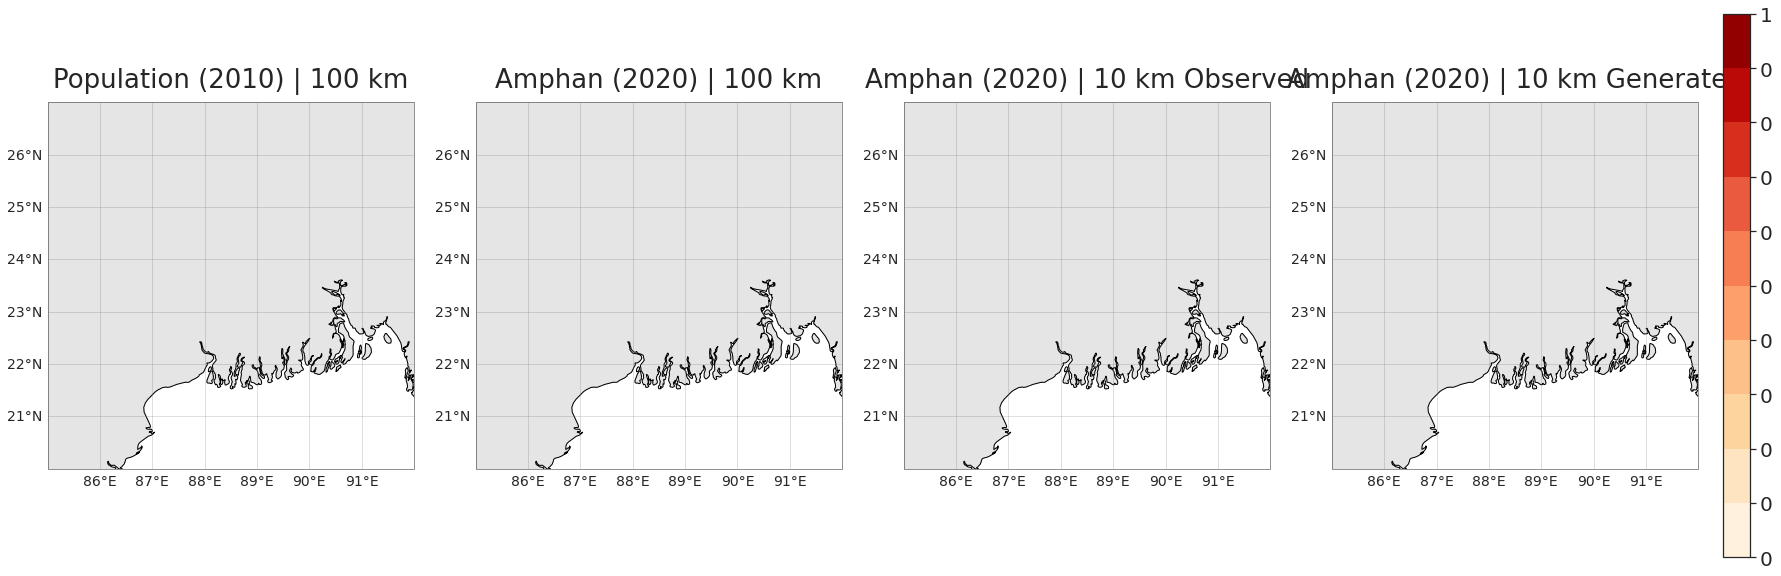

In [33]:
levels = [0.5, 1, 2, 3, 4, 5,7, 10,12,13, 15,18,20,25,30,35,40,45,50]
sns.set_style("white")
sns.set_context("notebook")
# define cmap
precip_cmap,precip_norm = make_cmap()
gridspec = {'width_ratios': [1,1,1,1,0.2]}
fig, axes = plt.subplots(1, 5, figsize=(32, 10), sharey=False,subplot_kw={'projection': ccrs.PlateCarree()}, gridspec_kw=gridspec)
axes[4].axis('off')

extent_1 = [119, 22, 122, 25]

# Irene 2011233N15301 validation NA
xlim_1 = (-80,-74)
ylim_1 = (33,39)

# xlim_1 = (-76.8,-75.8)
# ylim_1 = (36.5,37.5)

# xlim_1 = (-77.5,-77.25)
# ylim_1 = (35.45,35.7)

xlim_1 = (85,92)
ylim_1 = (20,27)

exposure_cmap = 'OrRd'

# Irene

# levels = [0,10000,50000,100000,200000,300000,400000,500000]

levels = [0, 50,100,150,200,250,300,350,400,450,500,550,600,650,700,750,1000]
levels = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
title = 'Population (2010) | 100 km'
axes[0] = plot_accumulated(cropped_pop['Population Density, v4.11 (2000, 2005, 2010, 2015, 2020): 2.5 arc-minutes'].values[2],cropped_pop['latitude'].values,cropped_pop['longitude'].values,
							vmin=0,vmax=1,cmap=exposure_cmap,levels = levels,plot='ax',centre_lats=centre_lats_1,
							centre_lons=centre_lons_1,intensity=intensity_1,ax=axes[0],mask_oceans=True,title=title)
levels = [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360]
levels = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
title = 'Amphan (2020) | 100 km'
axes[1] = plot_accumulated(cropped_inputs_regrid['precipitation'],cropped_pop['latitude'].values,cropped_pop['longitude'].values,
							vmin=0,vmax=1,cmap=exposure_cmap,levels = levels,plot='ax',centre_lats=centre_lats_1,
							centre_lons=centre_lons_1,intensity=intensity_1,ax=axes[1],mask_oceans=True,title=title)

title = 'Amphan (2020) | 10 km Observed'
axes[2] = plot_accumulated(cropped_obs_regrid['precipitation'],cropped_pop['latitude'].values,cropped_pop['longitude'].values,
							vmin=0,vmax=1,cmap=exposure_cmap,levels = levels,plot='ax',centre_lats=centre_lats_1,
							centre_lons=centre_lons_1,intensity=intensity_1,ax=axes[2],mask_oceans=True,title=title)
title = 'Amphan (2020) | 10 km Generated'
axes[3] = plot_accumulated(cropped_pred_regrid['precipitation'],cropped_pop['latitude'].values,cropped_pop['longitude'].values,
							vmin=0,vmax=1,cmap=exposure_cmap,levels = levels,plot='ax',centre_lats=centre_lats_1,centre_lons=centre_lons_1,
							intensity=intensity_1,ax=axes[3],mask_oceans=True,title=title,cbar=True,cax=axes[4])
axes[0].set_xlim(xlim_1)
axes[0].set_ylim(ylim_1)
axes[1].set_xlim(xlim_1)
axes[1].set_ylim(ylim_1)
axes[2].set_xlim(xlim_1)
axes[2].set_ylim(ylim_1)
axes[3].set_xlim(xlim_1)
axes[3].set_ylim(ylim_1)


plt.savefig('irene_exposure.png',bbox_inches='tight',dpi=600)